In [1]:
# Get the libraries
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

#### Let us Analyze the categorical data first

In [4]:
def tell_about_columns(df, col_names):
    for data in col_names:
        print(f"Column name: {data} {'*'*5} Nunique: {df[data].nunique()}, Dtype: {df[data].dtype}, Null Count: {df[data].isna().sum()}")
        print(f"Unique values with count are:\n{df[data].value_counts()}\n")


In [5]:
cat_cols = train_data.select_dtypes(include='object').columns.values
tell_about_columns(train_data, cat_cols)

Column name: City_Code ***** Nunique: 36, Dtype: object, Null Count: 0
Unique values with count are:
C1     8973
C2     7747
C3     4889
C4     3671
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
C26     499
C29     387
C25     366
C27     295
C33     286
C28     285
C32     160
C34     130
C30      58
C35      56
C36      36
C31      15
Name: City_Code, dtype: int64

Column name: Accomodation_Type ***** Nunique: 2, Dtype: object, Null Count: 0
Unique values with count are:
Owned     27951
Rented    22931
Name: Accomodation_Type, dtype: int64

Column name: Reco_Insurance_Type ***** Nunique: 2, Dtype: object, Null Count: 0
Unique values with count are:
Individual    40536
Joint         10346
Name: Reco_Insurance_Type, dtype: int64

Column name: Is_Spouse ***** Nunique: 2, Dtype: object, Null Count

In [6]:
def check_null(dataframe, percentage=True):
    if percentage==True:
        return round(dataframe.isnull().mean()[dataframe.isnull().mean()>0].apply(lambda x: x*100),3)
    else:
        return dataframe.isnull().sum()[dataframe.isnull().sum()>0]
    
check_null(train_data, percentage=False)

In [9]:
check_null(train_data, percentage=False)

Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
dtype: int64

In [8]:
train_data['Holding_Policy_Duration'] = pd.to_numeric(train_data['Holding_Policy_Duration'].str.replace(r"[^\d]", ""))

test_data['Holding_Policy_Duration'] = pd.to_numeric(test_data['Holding_Policy_Duration'].str.replace(r"[^\d]", ""))

In [9]:
train_data['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [10]:
# In approach 1 lets us drop the null values in this column
train_data['Health Indicator'] = train_data['Health Indicator'].fillna('X0')
test_data['Health Indicator'] = test_data['Health Indicator'].fillna('X0')

In [11]:
# Verify missing Holding_Policy_Type and Holding_Policy_Duration cols
last_re_date_set = set(train_data[(train_data['Holding_Policy_Type'].isna())]['ID'])
col_set = set(train_data[(train_data['Holding_Policy_Duration'].isna())]['ID'])
print(last_re_date_set-col_set)

set()


In [13]:
#awesome that means if policy type is not present then duration is also not present. so lets impute both with 0
train_data[['Holding_Policy_Type','Holding_Policy_Duration']] = train_data[['Holding_Policy_Type','Holding_Policy_Duration']].fillna(0)

In [14]:
# From abov it is clear that we need to prepare the test data also
test_data[['Holding_Policy_Type','Holding_Policy_Duration']] = test_data[['Holding_Policy_Type','Holding_Policy_Duration']].fillna(0)   

<AxesSubplot:>

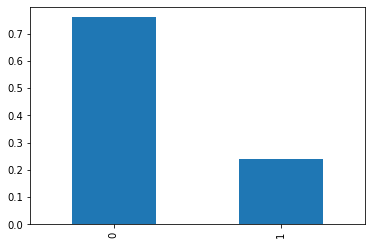

In [16]:
train_data['Response'].value_counts(normalize=True).plot(kind='bar')

In [17]:
# Now let us treat the categorical values, let us Label encode it in first approach.
cat_cols

array(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration'],
      dtype=object)

In [18]:
# object to label encoded
label_encode_dict = {}
for col in cat_cols:
    enc = train_data[col].unique()
    temp_di = {}
    for idx, val in enumerate(np.sort(enc)):
        temp_di[val] = idx
    label_encode_dict[col] = temp_di

In [20]:
def convert_into_labels(df, cols_to_label):
    for col in cols_to_label:
        df[col] = df[col].map(label_encode_dict[col])
    return df

In [22]:
train_data_le = convert_into_labels(train_data, cat_cols)

In [24]:
test_data_le = convert_into_labels(test_data, cat_cols)

In [25]:
X = train_data_le.drop(['ID','Response'], axis=1)
Y = train_data_le['Response']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=10)

In [28]:
#Let us check the shape of train and test data after split.
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40705, 12)
(10177, 12)
(40705,)
(10177,)


In [29]:
def evaluate_the_model(y_true, y_pred, y_pred_prob):
    accuracy_scr = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])
    return accuracy_scr, roc_auc

def get_models_data(models, X_train, Y_train, X_test, Y_test, get_train_score = False):
    trained_model = {}
    for model_name, model_code in models.items():
        print(f"Model code: {model_code}")
        model_code.fit(X_train, Y_train)
        if get_train_score:
            train_pred_lbl = model_code.predict(X_train)
            train_pred_proba = model_code.predict_proba(X_train)
            train_accuracy_scr, train_roc_auc = evaluate_the_model(Y_train, train_pred_lbl, train_pred_proba)
            print(f"Train Accuracy for the model is: {train_accuracy_scr:.2f}")
            print(f"Train roc_auc_score for the model is: {train_accuracy_scr:.2f}")
            print(f"{'-'*40}")
            
        pred_lbl = model_code.predict(X_test)
        pred_proba = model_code.predict_proba(X_test)
        accuracy_scr, roc_auc = evaluate_the_model(Y_test, pred_lbl, pred_proba)
        print(f"Test Accuracy for the model is: {accuracy_scr:.2f}")
        print(f"Test roc_auc_score for the model is: {roc_auc:.2f}")
        print(f"{'*'*60}")
        trained_model[model_name] = model_code
    return trained_model

def do_parameters_search(model, param_dict, x_train, y_train, nt=100):
    print(f"Model passed: {model}")
    cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    random_search_obj = RandomizedSearchCV(estimator = model, param_distributions = param_dict, n_iter = nt, \
                                           cv = cv,verbose = 100,random_state = 10,scoring = 'roc_auc', 
                                           return_train_score = True, n_jobs = -1)
    random_search_obj.fit(x_train,y_train)
    print(f"Mean_train_score is: {np.mean(random_search_obj.cv_results_['mean_train_score']):.3f}")
    print(f"Mean_test_score is: {np.mean(random_search_obj.cv_results_['mean_test_score']):.3f}")
    print(f"Best parameters are: {random_search_obj.best_params_}")
    return random_search_obj.best_params_

def create_submission_file(model, test_data, file_name):
    test_inp = test_data.drop('ID', axis=1)
    ids = test_data['ID']
    y_pred_final = model.predict(test_inp)
    op_df = pd.DataFrame({
        'ID': ids,
        'Response': y_pred_final
    })
    file_name = f"submission_files/{file_name}.csv"
    op_df.to_csv(file_name, index=False)
    print(f"{file_name} is created")
    

In [35]:
models = {
"logistic_regression": LogisticRegression(max_iter=500),
"decision_tree_gini": DecisionTreeClassifier(criterion="gini"),
"decision_tree_entropy": DecisionTreeClassifier(criterion="entropy"),
"gradint_boost_mse": GradientBoostingClassifier(),
"rf": RandomForestClassifier(),
"xgboost": XGBClassifier(objective= 'binary:logistic'),
"light_gbm": LGBMClassifier(objective='binary', class_weight='balanced')
}

In [36]:
trained_models = get_models_data(models, X_train, Y_train, X_test, Y_test, get_train_score=True)

Model code: LogisticRegression(max_iter=500)
Train Accuracy for the model is: 0.76
Train roc_auc_score for the model is: 0.76
----------------------------------------
Test Accuracy for the model is: 0.76
Test roc_auc_score for the model is: 0.52
************************************************************
Model code: DecisionTreeClassifier()
Train Accuracy for the model is: 1.00
Train roc_auc_score for the model is: 1.00
----------------------------------------
Test Accuracy for the model is: 0.67
Test roc_auc_score for the model is: 0.55
************************************************************
Model code: DecisionTreeClassifier(criterion='entropy')
Train Accuracy for the model is: 1.00
Train roc_auc_score for the model is: 1.00
----------------------------------------
Test Accuracy for the model is: 0.67
Test roc_auc_score for the model is: 0.55
************************************************************
Model code: GradientBoostingClassifier()
Train Accuracy for the model is: 0.

C:\Users\utkar\anaconda3\envs\hack\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train Accuracy for the model is: 0.80
Train roc_auc_score for the model is: 0.80
----------------------------------------
Test Accuracy for the model is: 0.75
Test roc_auc_score for the model is: 0.65
************************************************************
Model code: LGBMClassifier(class_weight='balanced', objective='binary')
Train Accuracy for the model is: 0.63
Train roc_auc_score for the model is: 0.63
----------------------------------------
Test Accuracy for the model is: 0.58
Test roc_auc_score for the model is: 0.67
************************************************************


In [37]:
# Set the grid
rf_grid = {
    'n_estimators': range(105,125,5),
    'max_depth': range(6,14,2),
    'min_samples_split': range(4,10,2)
}

# Get the optimal parameters.
rf_tuned_params = do_parameters_search(trained_models['rf'], rf_grid, X_train, Y_train)

# Tuned rf model
tuned_rf_model = {
"rf": RandomForestClassifier(**rf_tuned_params),
}

Model passed: RandomForestClassifier()
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\utkar\anaconda3\envs\hack\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Mean_train_score is: 0.753
Mean_test_score is: 0.615
Best parameters are: {'n_estimators': 120, 'min_samples_split': 4, 'max_depth': 12}


In [40]:
tuned_rf_model_op = get_models_data(tuned_rf_model, X_train, Y_train, X_test, Y_test, get_train_score=True)

Model code: RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=120)
Train Accuracy for the model is: 0.76
Train roc_auc_score for the model is: 0.76
----------------------------------------
Test Accuracy for the model is: 0.76
Test roc_auc_score for the model is: 0.63
************************************************************


ml_model = LGBMClassifier(subsample= 0.9,
 reg_lambda= 2.5,
 reg_alpha= 1,
 random_state= 108,
 objective= 'multiclass',
 n_estimators= 4000,
 min_split_gain= 0.5,
 min_data_in_leaf= 20,
 metric= 'multi_logloss',
 max_depth= 8,
 learning_rate= 0.01,
 colsample_bytree= 1,
 boosting_type= 'gbdt')


#### Create subbmission files below

In [ ]:
create_submission_file(models['rf'], test_data_le, 'rf_model1')

In [ ]:
create_submission_file(tuned_rf_model_op['rf'], test_data_le, 'lgm_base1')